In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd 
from IPython.display import Image, display 

In [2]:
from keras.preprocessing import image, sequence
from keras.models import Model
from keras.layers import Input, Dense, GRU, Embedding, TimeDistributed
from keras.applications import ResNet50

Using TensorFlow backend.


In [3]:
with open('./indices_to_words.pickle', 'rb') as f:
    indices_to_words = pickle.load(f)
with open('./words_to_indices.pickle', 'rb') as f: 
    words_to_indices = pickle.load(f)

In [4]:
test_images = pd.read_csv('./Flickr8k_text/TestImages.txt', delimiter='\t')

In [5]:
test_images_data = test_images.values

In [6]:
test_imgs_with_sents = {}
for image_data in test_images_data:
    if test_imgs_with_sents.get(image_data[0]) is None:
        test_imgs_with_sents[image_data[0]] = []
    test_imgs_with_sents[image_data[0]].append(image_data[1])

In [7]:
embedding_size = 128
maxLen = 40
vocab_size = 8919 
img_emb_size = 2048
state_size = 512

In [8]:
img_input = Input(shape=(img_emb_size, ), name='Image-Input')
img_output = Dense(state_size, activation='tanh', name='Image-output')

In [9]:
decoder_input = Input(shape=(40,), name='decoder-input')

In [10]:
decoder_embedding = Embedding(input_dim = vocab_size, output_dim = embedding_size, input_length = maxLen, name='decoder-embedding')

In [11]:
decoder_layer1 = GRU(state_size, name='decoder-layer-1', return_sequences = True)
decoder_layer2 = GRU(state_size, name='decoder-layer-2', return_sequences = True)
decoder_layer3 = GRU(state_size, name='decoder-layer-3', return_sequences = True)

In [12]:
decoder_time_dense = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoder-output')

In [13]:
initial_state = img_output(img_input)
net = decoder_input
net = decoder_embedding(net)
net = decoder_layer1(net, initial_state = initial_state)
net = decoder_layer2(net, initial_state = initial_state)
net = decoder_layer3(net, initial_state = initial_state)

In [14]:
decoder_output = decoder_time_dense(net)

In [15]:
model = Model(inputs=[img_input, decoder_input], output=[decoder_output])

/Users/hardik/Virtualenvs/mlcb/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder-input (InputLayer)      (None, 40)           0                                            
__________________________________________________________________________________________________
Image-Input (InputLayer)        (None, 2048)         0                                            
__________________________________________________________________________________________________
decoder-embedding (Embedding)   (None, 40, 128)      1141632     decoder-input[0][0]              
__________________________________________________________________________________________________
Image-output (Dense)            (None, 512)          1049088     Image-Input[0][0]                
__________________________________________________________________________________________________
decoder-la

In [17]:
model.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy')
model.load_weights('./model_weights.h5')

In [18]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3), pooling='avg')

In [19]:
def processImg(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return resnet.predict(im)
    

In [20]:
def predictCaptions(img_path):
    img_emb = processImg(img_path)
    decoder_input = np.zeros((1,maxLen), dtype=np.int)
    token_int = words_to_indices['<start>']
    count_tokens = 0
    sentence = []
    while True:
        decoder_input[0, count_tokens] = token_int
        x_data = {
            'Image-Input': img_emb,
            'decoder-input': decoder_input
        }
        preds = model.predict(x_data)
        token_probs = preds[0,count_tokens,:]
        token_int = np.argmax(token_probs)
        word = indices_to_words[token_int]
        count_tokens+=1
        if word == '<end>' or count_tokens > maxLen:
            break
        sentence.append(word)
    return ' '.join(sentence)

In [21]:
images = list(test_imgs_with_sents.keys())
base_path = './Flicker8k_Dataset/'

In [22]:
def getImages(num_images):
    for ix in range(num_images):
        img_idx = np.random.randint(0, len(images))
        image_path = base_path + images[img_idx]
        img = Image(filename=image_path)
        display(img)
        print("Actual Captions :- ")
        for sent in test_imgs_with_sents[images[img_idx]]:
            print(sent[8:-6])
        caption = predictCaptions(image_path)
        print("\nPredicted Caption : " + caption)

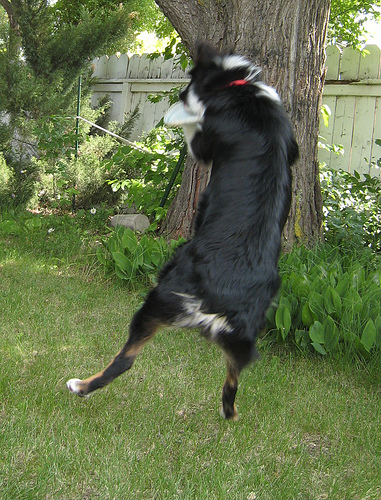

Actual Captions :- 
a black and white dog jumping in the air to catch a Frisbee
A black and white dog jumping in a yard .
A black dog jumps for a Frisbee in a backyard with a white fence .
A dog catches a flying disk in a yard with a tree .
A jumping dog in motion .

Predicted Caption : A black dog is trying to catch a stick in its mouth .


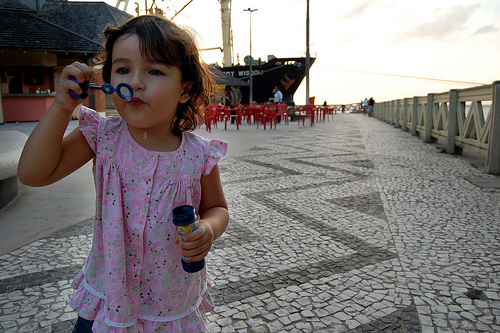

Actual Captions :- 
A girl in a pink dress blows bubbles on a wharf .
A girl wearing a dress is blowing bubbles at a dock .
A little girl blows bubbles in a courtyard with a ship in the background .
Small girl blowing bubbles outside .
The girl in the pink dress is blowing bubbles on a walkway in front of a black ship .

Predicted Caption : A girl in a pink dress is standing in front of a house .


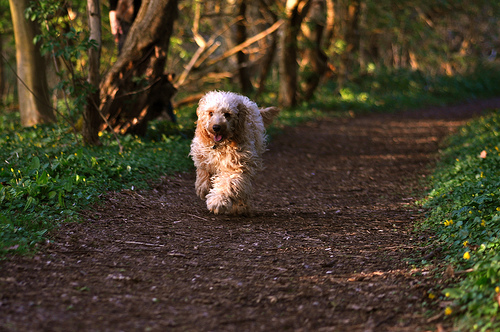

Actual Captions :- 
A dog runs along a forest lane .
A pale dog is running along a dirt path .
A shaggy dog runs down a dirt trail in a lush forest .
A white and brown shaggy dog is running down a dirt path in a park .
The curly haired white dog is running down a wooded path .

Predicted Caption : A dog with a toy in its mouth runs through the grass .


In [31]:
getImages(3)